# Importing

In [9]:
import joblib
import pickle
import tensorflow_datasets as tfds
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras import models, layers,  regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Benchmark - Using VadarSentiment

In [10]:
# New words and values to update the Lexicon.
new_words = {
    'crushes': 10,
    'beats': 5,
    'increase':10,
    'increasing':10,
    'long': 50,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
    'drops':-100,
    'dropping':-200,
    'falling':-100
}

In [11]:
# Initilise the analyser
analyser = SentimentIntensityAnalyzer()

# Using the analyser to analyse a negative sentiment, without the lexicon updates
score = analyser.polarity_scores("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.")
print(score)

# Using the analyser to analyse the same negative sentiment, with the lexicon updates
analyser.lexicon.update(new_words)
# Example
score = analyser.polarity_scores("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.")
print(score)

{'neg': 0.108, 'neu': 0.74, 'pos': 0.152, 'compound': 0.1675}
{'neg': 0.884, 'neu': 0.096, 'pos': 0.02, 'compound': -0.9992}


# 2. Using LSTM model trained on IMDB dataset from tensorflow

Vocabulary size: 8185
Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."
4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .
Epoch 1/10
391/391 [==============================] - 91s 221ms/step - loss: 0.6887 - accuracy: 0.5050 - val_loss: 0.4678 - val_accuracy: 0.7812
Epoch 2/10
391/391 [==============================] - 85s 217ms/step - loss: 0.4267 - accuracy: 0.8163 - val_loss: 0.3606 - val_accuracy: 0.8594
Epoch 3/10
391/391 [==============================] - 86s 219ms/step - loss: 0.2861 - accuracy: 0.8938 - val_loss: 0.3465 - val_accuracy: 0.8745
Epoch 4/10
391/391 [==============================] - 85s 218ms/step - loss: 0.2270 - accuracy: 0.9223 - val_loss: 0.3500 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 86s 219ms/step - loss: 0.1950 - accuracy: 0.9357 - val_loss: 0.4152 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] 

[[-3.759153]]


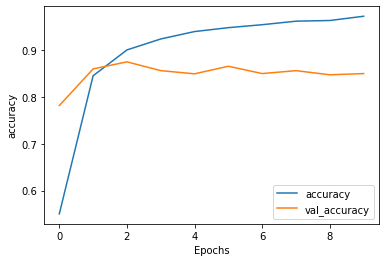

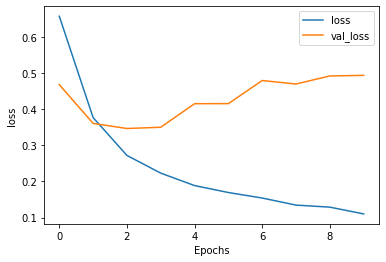

In [12]:
'''
REFERENCES:
https://www.tensorflow.org/tutorials/text/text_classification_rnn
and external runable version
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb#scrollTo=hw86wWS4YgR2
'''

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

encoder = info.features['text'].encoder

print('Vocabulary size: {}'.format(encoder.vocab_size))

sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string

for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, ([-1],[]))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, ([-1],[]))

def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad, model):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)



lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Change epochs to 10 to reduce overfitting

history = lstm.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = lstm.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False, model = lstm)
print(predictions)

# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True, model = lstm)
print(predictions)

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')




## Example

In [13]:
new_prediction = sample_predict("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", pad=True, model = lstm)
print(new_prediction)

new_prediction = sample_predict("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", pad=False, model = lstm)
print(new_prediction)


[[-0.310727]]


[[-0.48384848]]


## Save model

In [14]:
def sample_predict(sample_pred_text, encoder, pad, model):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [15]:
!mkdir -p saved_model
pickle.dump(encoder, open("saved_model/lstm_encoder.pickel", "wb"))

# load pickle
encoder_loaded = pickle.load(open("saved_model/lstm_encoder.pickel", "rb"))


In [16]:
lstm.save('saved_model/lstm')

lstm_loaded = tf.keras.models.load_model('saved_model/lstm')

# Check its architecture
lstm_loaded.summary()


INFO:tensorflow:Assets written to: saved_model/lstm/assets


INFO:tensorflow:Assets written to: saved_model/lstm/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

In [17]:
new_prediction = sample_predict("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", encoder = encoder_loaded, pad=False, model = lstm_loaded)
print(new_prediction)

[[-0.48384848]]


# 3. Building a Neural Network and train on IMDB Dataset

In [18]:
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
  
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

x_train  (40000, 10000)
x_test  (10000, 10000)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                500050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout

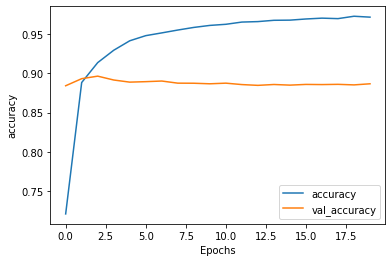

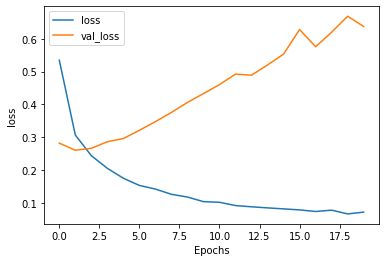

In [19]:
(training_data, training_label), (test_data, test_label) = imdb.load_data(num_words=10000, index_from=3)

data = np.concatenate((training_data, test_data), axis=0)
targets = np.concatenate((training_label, test_label), axis=0)
data = vectorize(data)
targets = np.array(targets).astype("float32")
x_test = data[:10000]
test_label = targets[:10000]
x_train = data[10000:]
training_label = targets[10000:]

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

NN = models.Sequential()
NN.add(layers.Dense(50,activation = "relu", input_shape=(10000, )))
NN.add(layers.Dropout(0.5))
NN.add(layers.Dense(50, activation = "relu"))
NN.add(layers.Dropout(0.5))
NN.add(layers.Dense(50, activation = "relu"))
NN.add(layers.Dense(16, activation='relu'))
NN.add(layers.Dropout(0.5))
NN.add(layers.Dense(1, activation = "sigmoid"))
NN.summary()

NN.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

history = NN.fit(x_train, training_label, epochs=20, batch_size=512, validation_data=(x_test,test_label))

test_loss, test_acc = NN.evaluate(x_test, test_label)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Text preprocessing

In [20]:
TOP_WORDS = 10000
stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

In [21]:
word2index = imdb.get_word_index()
word2index = {k:(v+3) for k,v in word2index.items()}

import string
# preprocessing
def clean_symbols(text):
    
    for char in text:
        # remove punctuation but preserve symbols defined above 
        if char in string.punctuation and char != ' ':
            text = text.replace(char, '')
        # remove all other characters
        if char.isalpha() is False and char.isdigit() is False and char != ' ':
            text = text.replace(char, '')
          
    return ' '.join(text.split())

def clean_words(news, dimension = TOP_WORDS):
  cleaned = clean_symbols(news).lower()
  test=[]
  for word in word_tokenize(cleaned):
    if word in word2index:
      test.append(word2index[word])
    
  results = np.zeros(dimension)
  for _ , sequence in enumerate(test):
    if sequence < dimension:
      results[sequence] = 1

  results = np.reshape(results,(1, TOP_WORDS))

  return results

1646592/1641221 [==============================] - 0s 0us/step


## Example

In [22]:


example_1 = "The movie was not good. The animation and the graphics were terrible. I would not recommend this movie."
example_2 = "it is so good"
example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
def predict_sentiment(x_test, NN):

  x_test = clean_words(x_test, dimension = TOP_WORDS)
  prediction = NN.predict(x_test) 
  return prediction

In [23]:

predict_sentiment(example_3, NN)
predict_sentiment("it is good and let's have a try", NN)

array([[0.9595045]], dtype=float32)

## Save the model

In [24]:
!mkdir -p saved_model
NN.save('saved_model/nn')

NN_loaded = tf.keras.models.load_model('saved_model/nn')

NN_loaded.summary()

predict_sentiment("it is good and let's have a try", NN_loaded)

INFO:tensorflow:Assets written to: saved_model/nn/assets


INFO:tensorflow:Assets written to: saved_model/nn/assets


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                500050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

array([[0.9595045]], dtype=float32)

# 4. Sentiment Analysis based on online dataset
# Reference: https://www.kaggle.com/geminikeggler/stock-sentiment-analysis

# https://www.kaggle.com/geminikeggler/stock-sentiment-analysis-classification-nlp

In [25]:
df= pd.read_csv('Combined_News_DJIA.csv',encoding='ISO-8859-1')


In [26]:
df.head()
df.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,Angela Merkel said the U.K. must file exit pap...,In a birth offering hope to a threatened speci...,Sky News Journalist Left Speechless As Leave M...,Giant panda in Macau gives birth to twins,Get out now: EU leader tells Britain it must i...,Sea turtle 'beaten and left for dead' on beach...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,'Do not let Scotland down now' : Scottish MEP ...,British pound could hit history-making dollar ...,"Merkel vows to strengthen EU, tells UK no 'che...","""Ryanair will not deploy new aircraft on route...","People, ever more greedy and stupid, destroy t...",Siemens freezes new UK wind power investment f...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,99-Million-Yr-Old Bird Wings Found Encased in ...,A chatbot programmed by a British teenager has...,The Philippine president-elect said Monday he ...,Former Belgian Prime Minister ridicules Nigel ...,Brexiteer Nigel Farage To EU: 'You're Not Laug...,Islamic State bombings in southern Yemen kill ...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says p

In [27]:
train = df[df['Date'] < '2015-01-01']
test = df[df['Date'] > '2014-12-31']

In [28]:
train.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [29]:
test.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1611,2015-01-02,1,Most cases of cancer are the result of sheer b...,Iran dismissed United States efforts to fight ...,Poll: One in 8 Germans would join anti-Muslim ...,UK royal family's Prince Andrew named in US la...,Some 40 asylum-seekers refused to leave the bu...,Pakistani boat blows self up after India navy ...,Sweden hit by third mosque arson attack in a week,940 cars set alight during French New Year,Salaries for top CEOs rose twice as fast as av...,"Norway violated equal-pay law, judge says: Jud...",Imam wants radical recruiters of Muslim youth ...,"Saudi Arabia beheaded 83 people in 2014, the m...",'A living hell' for slaves on remote South Kor...,"Worlds 400 richest get richer, adding $92bn in...","Rental Car Stereos Infringe Copyright, Music R...",Ukrainian minister threatens TV channel with c...,Palestinian President Mahmoud Abbas has entere...,Israeli security center publishes names of 50 ...,The year 2014 was the deadliest year yet in Sy...,A Secret underground complex built by the Nazi...,Restrictions on Web Freedom a Major Global Iss...,Austrian journalist Erich Mchel delivered a pr...,Thousands of Ukraine nationalists march in Kiev,Chinas New Years Resolution: No More Harvestin...,Authorities Pull Plug on Russia's Last Politic...
1612,2015-01-05,0,Moscow-&gt;Beijing high speed train will reduc...,Two ancient tombs were discovered in Egypt on ...,China complains to Pyongyang after N Korean so...,Scotland Headed Towards Being Fossil Fuel-Free...,Prime Minister Shinzo Abe said Monday he will ...,Sex slave at centre of Prince Andrew scandal f...,Gay relative of Hamas founder faces deportatio...,The number of female drug addicts in Iran has ...,"After Decades of Searching, the Causeway for t...",India lost 64 tigers in 2014,"Lizard Squad hacking of Sony was ""huge marketi...",Russia 'may face chaos' if extra sanctions imp...,The Saudi air and land forces carry out an att...,ISIL is reportedly setting up a bank in attemp...,Israel to brand anti-assimilation group Lehava...,The Islamic State has approved a 2015 budget o...,"Iceland To Withdraw EU Application, Lift Capit...",Blackfield Capital Founder Goes Missing: The v...,Rocket stage crashes back to Earth in rural Ch...,2 Dead as Aircraft Bombs Greek Tanker in Libya...,Belgian murderer Frank Van Den Bleeken to die ...,Czech President criticizes Ukrainian PM; says ...,3 Vietnamese jets join search for 16 missing F...,France seeks end to Russia sanctions over Ukraine,China scraps rare earths caps
1613,2015-01-06,0,US oil falls below $50 a barrel,"Toyota gives away 5,680 fuel cell patents to b...",Young Indian couple who had been granted polic...,A senior figure in Islamic States self-declare...,Fukushima rice passes radiation tests for 1st ...,Nearly all Spanish parties guilty of financial...,King Abdullah to abdicate Saudi Throne,Taliban Commander Caught Networking On LinkedIn,Mexican missing students: mayor's wife charged...,New York Times reporter James Risen refused on...,S. Korea sends sweet potatoes to N. Korea for ...,Turkey: Dutch journalist Frederike Geerdink de...,"KUALA LUMPUR, Jan 4 Islam prohibits its marri...","Iraqi MP:'Iran and their Top General, Qassem S...","Pakistan offers $100,000 bounty for Taliban le...",Thousands of Indians have fled from their home...,Turkey sacks judges who oversaw Erdogan corrup...,SpaceX Falcon 9 launch and recovery has been a...,CNN: Americans charged in botched Gambia coup,Islamic State 'Police' Official Beheaded.,Libya bans Palestinians from country to preven...,A judicial inquiry was opened in France on Mon...,Video has captured the moment a cameraman was ...,Syria has complained to the United Nations tha...,"Tests over, India set to make the iris of bigg..."
1614,2015-01-07,1,'Shots fired' at French magazine HQ,90% of Bibi Netanyahus Campaign Funds From U.S.,ISIS behea

## Preparing Training and Test Dataset

In [30]:
data= train.iloc[:,2:27]
data.replace("[^a-zA-Z]"," ",regex=True, inplace=True)

# RENAMING COLUMN NAME FOR EASE OF ACCESS
list1=[i for i in range(25)]
new_Index=[str(i) for i in list1]
data.columns= new_Index
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b Georgia downs two Russian warplanes as cou...,b BREAKING Musharraf to be impeached,b Russia Today Columns of troops roll into So...,b Russian tanks are moving towards the capital...,b Afghan children raped with impunity U N ...,b Russian tanks have entered South Ossetia...,b Breaking Georgia invades South Ossetia Rus...,b The enemy combatent trials are nothing but...,b Georgian troops retreat from S Osettain cap...,b Did the U S Prep Georgia for War with Russia,b Rice Gives Green Light for Israel to Attack ...,b Announcing Class Action Lawsuit on Behalf of...,b So Russia and Georgia are at war and the N...,b China tells Bush to stay out of other countr...,b Did World War III start today,b Georgia Invades South Ossetia if Russia ge...,b Al Qaeda Faces Islamist Backlash,b Condoleezza Rice The US would not act to p...,b This is a busy day The European Union has ...,b Georgia will withdraw soldiers from Ir...,b Why the Pentagon Thinks Attacking Iran is a ...,b Caucasus in crisis Georgia invades South Os...,b Indian shoe manufactory And again in a se...,b Visitors Suffering from Mental Illnesses Ban...,b No Help for Mexico s Kidnapping Surge
1,b Why wont America and Nato help us If they w...,b Bush puts foot down on Georgian conflict,b Jewish Georgian minister Thanks to Israeli ...,b Georgian army flees in disarray as Russians ...,b Olympic opening ceremony fireworks faked,b What were the Mossad with fraudulent New Zea...,b Russia angered by Israeli military sale to G...,b An American citizen living in S Ossetia blam...,b Welcome To World War IV Now In High Definit...,b Georgia s move a mistake of monumental prop...,b Russia presses deeper into Georgia U S say...,b Abhinav Bindra wins first ever Individual Ol...,b U S ship heads for Arctic to define territ...,b Drivers in a Jerusalem taxi station threaten...,b The French Team is Stunned by Phelps and the...,b Israel and the US behind the Georgian aggres...,b Do not believe TV neither Russian nor Geor...,b Riots are still going on in Montreal Canada...,b China to overtake US as largest manufacturer,b War in South Ossetia PICS,b Israeli Physicians Group Condemns State Tort...,b Russia has just beaten the United States ov...,b Perhaps the question about the Georgia R...,b Russia is so much better at war,b So this is what it s come to trading sex fo...
2,b Remember that adorable year old who sang a...,b Russia ends Georgia operation,b If we had no sexual harassment we would hav...,b Al Qa eda is losing support in Iraq because ...,b Ceasefire in Georgia Putin Outmaneuvers the...,b Why Microsoft and Intel tried to kill the XO...,b Stratfor The Russo Georgian War and the Bal...,b I m Trying to Get a Sense of This Whole Geor...,b The US military was surprised by the timing ...,b U S Beats War Drum as Iran Dumps the Dollar,b Gorbachev Georgian military attacked the S...,b CNN use footage of Tskhinvali ruins to cover...,b Beginning a war as the Olympics were opening...,b pyramids as large as the Luxor stacked in...,b The Top Party Cities in the World,b U S troops still in Georgia did you know t...,b Why Russias response to Georgia was right,b Gorbachev accuses U S of making a serious ...,b Russia Georgia and NATO Cold War Two,b Remember that adorable year old who led y...,b War in Georgia The Israeli connection,b All signs point to the US encouraging Georgi...,b Christopher King argues that the US and NATO...,b America The New Mexico,b BBC NEWS Asia Pacific Extinction by man...
3,b U S refuses Israel weapons to attack Iran ...,b When the president ordered to attack Tskhinv...,b Israel clears troops who killed Reuters cam...,b Britain s policy of being tough on drugs is...,b Body of year old found in trunk Latest ...,b China has moved million quake survivors...,b Bush announces Operation Get All Up In Russi...,b Russian forces sink Georgian ships,b The commander of a Navy air reconnaissance s...,b of CNN readers Russia s ac

In [31]:
for index in new_Index:
    data[index]=data[index].str.lower()
data.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,b rice gives green light for israel to attack ...,b announcing class action lawsuit on behalf of...,b so russia and georgia are at war and the n...,b china tells bush to stay out of other countr...,b did world war iii start today,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge


In [32]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,b rice gives green light for israel to attack ...,b announcing class action lawsuit on behalf of...,b so russia and georgia are at war and the n...,b china tells bush to stay out of other countr...,b did world war iii start today,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge
1,b why wont america and nato help us if they w...,b bush puts foot down on georgian conflict,b jewish georgian minister thanks to israeli ...,b georgian army flees in disarray as russians ...,b olympic opening ceremony fireworks faked,b what were the mossad with fraudulent new zea...,b russia angered by israeli military sale to g...,b an american citizen living in s ossetia blam...,b welcome to world war iv now in high definit...,b georgia s move a mistake of monumental prop...,b russia presses deeper into georgia u s say...,b abhinav bindra wins first ever individual ol...,b u s ship heads for arctic to define territ...,b drivers in a jerusalem taxi station threaten...,b the french team is stunned by phelps and the...,b israel and the us behind the georgian aggres...,b do not believe tv neither russian nor geor...,b riots are still going on in montreal canada...,b china to overtake us as largest manufacturer,b war in south ossetia pics,b israeli physicians group condemns state tort...,b russia has just beaten the united states ov...,b perhaps the question about the georgia r...,b russia is so much better at war,b so this is what it s come to trading sex fo...
2,b remember that adorable year old who sang a...,b russia ends georgia operation,b if we had no sexual harassment we would hav...,b al qa eda is losing support in iraq because ...,b ceasefire in georgia putin outmaneuvers the...,b why microsoft and intel tried to kill the xo...,b stratfor the russo georgian war and the bal...,b i m trying to get a sense of this whole geor...,b the us military was surprised by the timing ...,b u s beats war drum as iran dumps the dollar,b gorbachev georgian military attacked the s...,b cnn use footage of tskhinvali ruins to cover...,b beginning a war as the olympics were opening...,b pyramids as large as the luxor stacked in...,b the top party cities in the world,b u s troops still in georgia did you know t...,b why russias response to georgia was right,b gorbachev accuses u s of making a serious ...,b russia georgia and nato cold war two,b remember that adorable year old who led y...,b war in georgia the israeli connection,b all signs point to the us encouraging georgi...,b christopher king argues that the us and nato...,b america the new mexico,b bbc news asia pacific extinction by man...
3,b u s refuses israel weapons to attack iran ...,b when the president ordered to attack tskhinv...,b israel clears troops who killed reuters cam...,b britain s policy of being tough on drugs is...,b body of year old found in trunk latest ...,b china has moved million quake survivors...,b bush announces operation get all up in russi...,b russian forces sink georgian ships,b the commander of a navy air reconnaissance s...,b of cnn readers russia s ac

In [33]:
headlines=[]
for row in range(0,len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row,0:25]))

## Random Forest Classifier with CountVectorizer

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

countvector= CountVectorizer(ngram_range=(2,2))
traindataset= countvector.fit_transform(headlines) # CONVERTING ALL THE HEADLINES INTO VECTORS

random_classifier= RandomForestClassifier(n_estimators=200,criterion='entropy')
random_classifier.fit(traindataset,train['Label'])

test_transform=[]
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset= countvector.transform(test_transform)
predictions= random_classifier.predict(test_dataset)

matrix= confusion_matrix(test["Label"],predictions)
print(matrix)
score= accuracy_score(test["Label"],predictions)
print(score)
report= classification_report(test['Label'],predictions)
print(report)

example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
example_3 = countvector.transform([example_3])
print(random_classifier.predict(example_3))
print(random_classifier.predict_proba(example_3))

[[  2 184]
 [  4 188]]
0.5026455026455027
              precision    recall  f1-score   support

           0       0.33      0.01      0.02       186
           1       0.51      0.98      0.67       192

    accuracy                           0.50       378
   macro avg       0.42      0.49      0.34       378
weighted avg       0.42      0.50      0.35       378

[1]
[[0.09 0.91]]


In [35]:
example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
example_3 = countvector.transform([example_3])
print(random_classifier.predict(example_3))
print(random_classifier.predict_proba(example_3))

[1]
[[0.09 0.91]]


## Random Forest Classifier with TfidfVectorizer

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

## IMPLEMENTING TF-IDF VECTORIZER
tfidf= TfidfVectorizer(ngram_range=(2,2))
traindataset= tfidf.fit_transform(headlines) 

random_classifier= RandomForestClassifier(n_estimators=200,criterion='entropy')
random_classifier.fit(traindataset,train['Label'])

test_transform=[]
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset= tfidf.transform(test_transform)
predictions= random_classifier.predict(test_dataset)

matrix= confusion_matrix(test["Label"],predictions)
print(matrix)
score= accuracy_score(test["Label"],predictions)
print(score)
report= classification_report(test['Label'],predictions)
print(report)

example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
example_3 = tfidf.transform([example_3])
print(random_classifier.predict(example_3))
print(random_classifier.predict_proba(example_3))

[[ 63 123]
 [ 55 137]]
0.5291005291005291
              precision    recall  f1-score   support

           0       0.53      0.34      0.41       186
           1       0.53      0.71      0.61       192

    accuracy                           0.53       378
   macro avg       0.53      0.53      0.51       378
weighted avg       0.53      0.53      0.51       378

[1]
[[0.205 0.795]]


## NaiveNaive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB
naive= MultinomialNB()

tfidf= TfidfVectorizer(ngram_range=(2,2))
traindataset= tfidf.fit_transform(headlines) 

naive.fit(traindataset,train['Label'])

test_transform=[]
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset= tfidf.transform(test_transform)
predictions= naive.predict(test_dataset)

matrix= confusion_matrix(test["Label"],predictions)
print(matrix)
score= accuracy_score(test["Label"],predictions)
print(score)
report= classification_report(test['Label'],predictions)
print(report)

example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
example_3 = tfidf.transform([example_3])
print(naive.predict(example_3))
print(naive.predict_proba(example_3))

[[  0 186]
 [  0 192]]
0.5079365079365079
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378

[1]
[[0.46626189 0.53373811]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM

In [38]:
from sklearn.svm import SVC

tfidf= TfidfVectorizer()
traindataset= tfidf.fit_transform(headlines) 

svc = SVC(probability=True, kernel='rbf')
svc.fit(traindataset,train['Label'])

test_transform=[]
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset= tfidf.transform(test_transform)
predictions= svc.predict(test_dataset)

matrix= confusion_matrix(test["Label"],predictions)
print(matrix)
score= accuracy_score(test["Label"],predictions)
print(score)
report= classification_report(test['Label'],predictions)
print(report)

example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
example_3 = tfidf.transform([example_3])
print(svc.predict(example_3))
print(svc.predict_proba(example_3))

[[  0 186]
 [  0 192]]
0.5079365079365079
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378

[0]
[[0.4391908 0.5608092]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
example_3 = "Investors are selling Tesla"
example_3 = tfidf.transform([example_3])
print(svc.predict(example_3))
print(svc.predict_proba(example_3))

[1]
[[0.45570922 0.54429078]]


# SVC trained on another dataset

In [40]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
import nltk
import pandas as pd
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.svm import SVC

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [41]:
data = pd.read_csv('all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [42]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')

    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            clean_text.append(w)
    return clean_text


In [43]:
# making list stopwords for removing stopwords from our text 
stop = set(stopwords.words('english'))
stop.update(punctuation)
print(stop)

{'all', '{', 'theirs', 'just', 'couldn', 'isn', 'our', 'same', 'as', 'not', 'having', '<', 'against', 'on', '}', 'out', 'it', 'itself', 'ma', 'at', 'she', '$', 'myself', 'because', 'nor', "hasn't", 'weren', "don't", "wasn't", "couldn't", 'during', 'no', 'both', 'only', 'more', 'm', 'an', 'through', '=', 'from', '.', 'these', 'wouldn', '(', 're', '+', "needn't", '[', '#', 'off', 'yourself', 'her', 'by', 'so', 's', "haven't", 'very', 'if', 'shouldn', 'under', 'have', 'am', 'a', 'when', "you'd", 'll', 'did', 'up', 'my', ':', 'had', 'once', 'him', 'his', 'which', 'into', 'over', 'didn', 'but', "mustn't", '&', 'each', 'them', 'most', 'were', 'shan', ',', 'such', 'hers', 'that', "that'll", 'aren', 'some', "won't", 'be', 'been', 'you', 'down', 'this', 'mustn', '|', 'yours', "you'll", "wouldn't", 'how', 'was', 'd', 'i', "didn't", 'where', 'for', 'in', '~', "she's", '-', ')', "shan't", 'too', 'the', 'to', "you've", 've', 'ours', 'doesn', 'between', 'doing', '%', 'what', ']', 'does', 'then', "do

In [44]:
def join_text(text):
    return " ".join(text)

In [45]:
data.text = data.text.apply(cleanText)
data.text = data.text.apply(join_text)

In [46]:
# splitting data.
x_train,x_test,y_train,y_test = train_test_split(data.text,data.sentiment,test_size = 0.2 , random_state = 0)

In [47]:
pos = x_train[y_train[y_train=='positive'].index]
neg = x_train[y_train[y_train=='negative'].index]
neutral = x_train[y_train[y_train=='negative'].index]

In [48]:
# creating a variable for count vectorizer which gives us features using the whole text of data.
count_vec = CountVectorizer(max_features=4000, ngram_range=(1,2), max_df=0.9, min_df=0)
# max_df insures to remove most frequent words as we discussed earlier.
# ngram_range is used to select words at a time like 1 or 2 like if a sentence have 'not happy' in text then it can mean two things if we pick the word 'happy' and pick the words 'not happy' both.

In [49]:
x_train_features = count_vec.fit_transform(x_train).todense()
x_test_features = count_vec.transform(x_test).todense()
x_train_features.shape, x_test_features.shape

((3876, 4000), (970, 4000))

In [50]:
svc = SVC(probability=True)
svc.fit(x_train_features, y_train)
y_pred = svc.predict(x_test_features)
print(accuracy_score(y_test,y_pred)*100)
print(classification_report(y_test, y_pred))

72.4742268041237
              precision    recall  f1-score   support

    negative       0.78      0.24      0.37       128
     neutral       0.71      0.98      0.82       575
    positive       0.80      0.40      0.53       267

    accuracy                           0.72       970
   macro avg       0.76      0.54      0.58       970
weighted avg       0.74      0.72      0.68       970



In [51]:
print(accuracy_score(y_test,y_pred)*100)
print(classification_report(y_test, y_pred))

72.4742268041237
              precision    recall  f1-score   support

    negative       0.78      0.24      0.37       128
     neutral       0.71      0.98      0.82       575
    positive       0.80      0.40      0.53       267

    accuracy                           0.72       970
   macro avg       0.76      0.54      0.58       970
weighted avg       0.74      0.72      0.68       970



In [52]:
example = "This is fantastic!"
example = cleanText(example)
example = join_text(example)
print(example)

test_news = count_vec.transform([example]).todense()
print(svc.predict_proba(test_news))

fantastic
[[0.01499499 0.92977096 0.05523405]]


## Save the model

In [53]:
pickle.dump(count_vec, open("saved_model/count_vector.pickel", "wb"))
# save
joblib.dump(svc, "saved_model/svc.pkl") 

# load pickle
count_vec_loaded = pickle.load(open("saved_model/count_vector.pickel", "rb"))

# load
svc_loaded = joblib.load("saved_model/svc.pkl")

example = "This is fantastic!"
example = cleanText(example)
example = join_text(example)
print(example)

test_news = count_vec_loaded.transform([example]).todense()
print(svc_loaded.predict_proba(test_news))

fantastic
[[0.01499499 0.92977096 0.05523405]]


In [56]:
def svc_predict(svc, count_vec, news):
    news_processed = cleanText(news)
    news_processed = join_text(news_processed)
    
    test_news = count_vec.transform([news_processed]).todense()
    return svc.predict_proba(test_news)

# Combine all models together to give the final rating

In [57]:
def predict_rating(news, lstm, NN):
    benchmark_rating = analyser.polarity_scores(news)['compound']
    print(f'result from vadar: {benchmark_rating:.2f}')

    # Predicted by LSTM model, using padding = True
    rating_lstm = sample_predict(news, encoder_loaded, pad=True, model = lstm)[0][0]
    print(f'result from lstm: {rating_lstm:.2f}')
  
    # predicted by NN
    rating_NN = predict_sentiment(news, NN)[0][0]
    print(f'result from Neural Network: {rating_NN:.2f}')
    
    # predictd by SVC
    rating_svc = svc_predict(svc_loaded, count_vec_loaded, news)[0]
    print(f"result from SVC: positive:{rating_svc[2]:.2f}, neutral:{rating_svc[1]:.2f}, negative:{rating_svc[0]:.2f}")

    if np.argmax(rating_svc) == 2:
        # the news is in the positive side
        if benchmark_rating >= 0.05 and rating_lstm >=0 and rating_NN >= 0.5:
            return "Strongly Positive", rating_svc[2]
        elif benchmark_rating >= 0.05 or rating_lstm >=0 or rating_NN >= 0.5:
            return "Slightly Positive", rating_svc[2]
        else:
            return "Positive", rating_svc[2]

    elif np.argmax(rating_svc) == 0:
        # the news is in the negative side
        if benchmark_rating <-0.05 and rating_lstm <0 and rating_NN < 0.5:
            return "Strongly Negative", rating_svc[0]* -1
        elif benchmark_rating <-0.05 or rating_lstm <0 or rating_NN < 0.5:
            return "Slightly Negative", rating_svc[0] * -1
        else:
            return "Negative", rating_svc[0] * -1

    else:
        if benchmark_rating < -0.05:
            return "Negative", rating_svc[0] * -1
        if benchmark_rating > 0.05:
            return "Positive", rating_svc[2]
        if rating_svc[1] > 0.7:
            return "Neutral", rating_svc[1] * 0
        else:
            if rating_svc[0] > rating_svc[2]:
                return "Slightly Negative", rating_svc[0] * -1
            else:
                return "Slightly Positive", rating_svc[2]

In [58]:
predict_rating("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", lstm, NN)

result from vadar: -1.00
result from lstm: -0.31
result from Neural Network: 0.00
result from SVC: positive:0.09, neutral:0.89, negative:0.02


('Negative', -0.02164393735425806)

In [59]:
predict_rating("Apple Stock displays good prospect in the future, investors highs high", lstm, NN)

result from vadar: 0.62
result from lstm: 1.69
result from Neural Network: 0.93
result from SVC: positive:0.41, neutral:0.54, negative:0.05


('Positive', 0.4121132626755566)

In [60]:
predict_rating("Apple New iphone is coming", lstm, NN)

result from vadar: 0.00
result from lstm: 1.04
result from Neural Network: 0.98
result from SVC: positive:0.06, neutral:0.93, negative:0.01


('Neutral', 0.0)

In [61]:
predict_rating("The market is falling", lstm, NN)

result from vadar: -1.00
result from lstm: 0.48
result from Neural Network: 0.22
result from SVC: positive:0.05, neutral:0.93, negative:0.02


('Negative', -0.018970463804799848)

In [62]:
!zip -r saved_model.zip saved_model

from google.colab import files
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/count_vector.pickel (deflated 59%)
  adding: saved_model/nn/ (stored 0%)
  adding: saved_model/nn/variables/ (stored 0%)
  adding: saved_model/nn/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: saved_model/nn/variables/variables.index (deflated 67%)
  adding: saved_model/nn/assets/ (stored 0%)
  adding: saved_model/nn/saved_model.pb (deflated 89%)
  adding: saved_model/svc.pkl (deflated 100%)
  adding: saved_model/lstm_encoder.pickel (deflated 98%)
  adding: saved_model/lstm/ (stored 0%)
  adding: saved_model/lstm/variables/ (stored 0%)
  adding: saved_model/lstm/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/lstm/variables/variables.index (deflated 70%)
  adding: saved_model/lstm/assets/ (stored 0%)
  adding: saved_model/lstm/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>